In [1]:
import mesh_to_sdf
import trimesh
import pyrender
import numpy as np
import time
import os

# Construction of the matrix of 60 cars

In [2]:
def sdf_binary(mesh):
    '''calculate binary representation vector of a car shape
       input: mesh
       output: vector representation of a mesh'''
    
    start_time = time.time()
    
    #original mass center and bounding box
#     print(mesh.center_mass)
    bbx_ex = mesh.bounding_box.primitive.extents
#     print(bbx_ex)#bounding box size

    #set mass center to (0,0,0)
    mesh.vertices -= mesh.center_mass
#     print(mesh.center_mass)

    #rescale the mesh to real scale in meters
    mesh.vertices = mesh.vertices*5
#     print(bbx_ex) #bounding box size
    
    #construct points matrix used to enclude the mesh
    x_p = np.linspace(-2.5,2.5,50) 
    y_p = np.linspace(-1.0,1.0,20)
    z_p = np.linspace(-1.0,1.0,20)
    points = np.vstack(np.meshgrid(x_p,y_p,z_p)).reshape(3,-1).T
    
    #calculate the sdf of each point to the mesh
    sd = mesh_to_sdf.mesh_to_sdf(mesh, points, 
                        surface_point_method='scan', sign_method='normal', 
                        bounding_radius=None, scan_count=100, scan_resolution=400, 
                        sample_point_count=10000000, normal_sample_count=11)
    
    #transform the sdf using a presence function
    #outside the mesh is 0 and inside the mesh is 1
    for i, sdf in enumerate(sd):
        if sdf > 0: # outside the boundary
            sdf = 0
        else:       # on the boundary or inside the boundary
            sdf = 1
        sd[i] = sdf
    
    #show execution time
    print("execution time: %s" %(time.time() - start_time))
    
    return sd

In [3]:
#Get a np.array holding all vector representations of 60 car models
sd_list = []
names = [f for f in os.listdir('./final_car60/')]
for name in names:
    directory = os.path.join('./final_car60/' + name)
    mesh = trimesh.load(directory)
    sd = sdf_binary(mesh)
    print(name)
    sd_list.append(sd)

execution time: 16.348927974700928
b01.obj
execution time: 16.818251848220825
b02.obj
execution time: 17.59190082550049
b03.obj
execution time: 23.760118007659912
b04.obj
execution time: 16.036431074142456
b05.obj
execution time: 18.758228063583374
b06.obj
execution time: 20.650297164916992
b07.obj
execution time: 17.738977909088135
b08.obj
execution time: 16.987776041030884
b09.obj
execution time: 18.587809085845947
b10.obj
execution time: 17.16992688179016
b11.obj
execution time: 18.722342014312744
b12.obj
execution time: 17.658952951431274
b13.obj
execution time: 20.55295705795288
b14.obj
execution time: 16.968953132629395
b15.obj
execution time: 16.03374409675598
b16.obj
execution time: 26.86218500137329
b17.obj
execution time: 21.674726009368896
b18.obj
execution time: 16.237592220306396
b19.obj
execution time: 20.890460968017578
c01.obj
execution time: 20.95894503593445
c02.obj
execution time: 22.859715223312378
c03.obj
execution time: 17.8396999835968
c04.obj
execution time: 18.

In [4]:
sd_array = np.array(sd_list)
print(sd_array)
#np.savetxt('v_rep_car60',sd_array,newline=" ")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
print(len(sd_array))

60


# Data visualization of the matrix of 60 cars

In [6]:
from sklearn import neighbors, datasets, manifold
from scipy import linalg
from scipy.linalg import eigh
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [7]:
#### Neighbor search
# we will implement K-nearest neighbor search
def knn_Mat(X, K, t=2.0, dist_metric="euclidean", algorithm="ball_tree"):
    """ compute the neighborhood matrix

    Keyword arguments:
        X: np.array of data, each row(not column) is associated with one car. (A car is represented by a vector)
        K: number of neighbors to seek for each element (the element itself is excluded)
        dist_metric: with which metric to compute the distances
        algorithm: which which algorithm to use

    return:
        the neighborhood matrix
    """

    n, p = X.shape  # n: number of elements, p: dimension (number of data per element)

    knn = neighbors.NearestNeighbors(K + 1, metric=dist_metric, algorithm=algorithm).fit(X)
    distances, nbors = knn.kneighbors(X)  # return k nearest neighbours of each member of X, nbors is array of indices 

    return (nbors[:, 1:])  # neighborhood matrix first one is the point itself, which should be excluded

In [8]:
#### calculation of reconstruction weights
def get_weights(X, nbors, reg, K):
    """ compute the weight matrix

    Keyword arguments:
        X: np.array of data, each row is associated with one car
        nbors; neighborhood matrix
        regularized term: avoid the covariance matrix to be singular #regularizer
        K: number of neighbours selected for each car

    return:
        the weight matrix
    """

    n, p = X.shape  # n number of car shapes, n rows and p columns (60 rows and 112000 columns in our case)

    Weights = np.zeros((n, n))

    for i in range(n):

        X_bors = X[nbors[i], :] - X[i]  # Gi in MLLE paper
        cov_nbors = np.dot(X_bors, X_bors.T)

        # regularization terms
        trace = np.trace(cov_nbors)
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        cov_nbors.flat[::K + 1] += R  # [::K+1] -> every K+1 step. Allows adding only on trace
        weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)  # solution to cov_nbors*weights = 1
        # optimal solution to min(cov_nbors*W)

        # normalizing
        weights = weights / weights.sum()
        # only ponderable weights of neighbours should be different from zero
        #Weights[i, nbors[i]] = weights # put all those weights into a matrix
        Weights[i, nbors[i]] = weights

    return (Weights)

In [9]:
#### Calculate the embedded data using the weights
# calculation of the new embedding
def Y_(Weights, d):
    """ reconstruct data into the low dimensional space

    Keyword arguments:
        Weights: weight matrix
        d: number of dimension in which to project onto (2 in our case)

    return:
        the dataset projected onto d dimensions
    """
    n, p = Weights.shape
    I = np.eye(n)
    m = (I - Weights)
    M = m.T.dot(m)

    eigvals, eigvecs = eigh(M, eigvals=(1, d), overwrite_a=True)
    ind = np.argsort(np.abs(eigvals))

    return (eigvecs[:, ind])  # we only keep the the most important vectors (?? xl)


In [10]:
def LLE_(X, K, d, nbors):
    """ proceed to various LLE steps

    Keyword arguments:
        X: dataset
        K: number of neighbours to seek
        d: on how many dimension to project the dataset

    return:
        the data set projected into d dimensions
    """
    reg = 0.001 # regularized term

    try:
        if nbors == None:
            nbors = knn_Mat(X, K)
    except:
        pass
    Weights = get_weights(X, nbors, reg, K)

    Y = Y_(Weights, d)
    
    return [Y, Weights, nbors]

In [11]:
X = sd_array
n_sample, sample_dim = np.shape(X)
K = 6 #in our case, K=6 gets the lowest reconstruction error
d = 2
nbors = None
Y, Weights, nbors = LLE_(X, K, d, nbors)
err = np.linalg.norm(Y - np.dot(Weights,Y),'fro')**2 # reconstruction error for Y (low dimensional data)

# print(Y)
# print(Weights)
# print(nbors)
# print(np.dot(Weights,Y))
print("Reconstruction error: %g" %err)

Reconstruction error: 0.0087597


In [12]:
# extracting the weights of neighbors for all shapes 
W_shapes = np.zeros((n_sample,K)) # W_shapes: weights extracted from Weight matrix
for i in range(n_sample):
    for j in range(K):
        n = nbors[i,:][j]
        W_shapes[i,j] = Weights[i,n]   
# print(W_shapes)

Text(0.5, 1.0, 'Projected data')

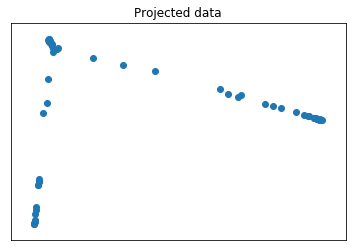

In [13]:
# # Plot result
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# y0 = Y[:, 0]
# y1 = Y[:, 1]
# ax1.scatter(y0,y1)
# plt.axis('tight')
# plt.xticks([]), plt.yticks([])
# plt.title('Projected data') 

Text(0.5, 1.0, 'Projected data')

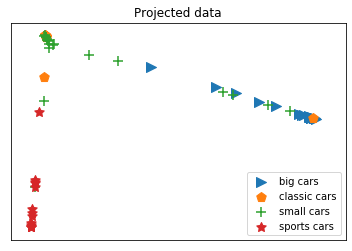

In [74]:
# Plot result
fig, ax = plt.subplots()
#fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(112)
# ax3 = fig.add_subplot(113)
# ax4 = fig.add_subplot(114)
x_b = Y[:19, 0]
y_b = Y[:19, 1]
x_c = Y[19:27, 0]
y_c = Y[19:27, 1]
x_s = Y[27:47, 0]
y_s = Y[27:47, 1]
x_sp = Y[47:, 0]
y_sp = Y[47:, 1]
# ax1.scatter(x_b,y_b)
# ax2.scatter(x_c,y_c)
# ax3.scatter(x_s,y_s)
# ax4.scatter(x_sp,y_sp)
plt.scatter(x_b,y_b, s=100, marker=">", label='big cars') #triangle 
plt.scatter(x_c,y_c, s=100, marker=(5,0), label='classic cars')#wubianxing
plt.scatter(x_s,y_s, s=100, marker="+", label='small cars')#plus
plt.scatter(x_sp,y_sp, s=100, marker=(5,1), label='sports cars')#stars
plt.legend(loc='lower right')
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data') 

# Get weights of a new car

In [48]:
start_time_new = time.time()

In [49]:
#### Neighbors search for a new added shape 
# we will implement K-nearest neighbor search
def knn_new(X, K, x_new, t=2.0, dist_metric="euclidean", algorithm="ball_tree"):
    """ compute the neighborhood matrix

    Keyword arguments:
        X: np.array of data, each row(not column) is associated with one car. (A car is represented by a vector)
        K: number of neighbors to seek for each element (the element itself is excluded)
        dist_metric: with which metric to compute the distances
        algorithm: which which algorithm to use

    return:
        the neighborhood matrix
    """

    n, p = X.shape  # n: number of elements, p: dimension (number of data per element)

    knn = neighbors.NearestNeighbors(K + 1, metric=dist_metric, algorithm=algorithm).fit(X)
    nbors = knn.kneighbors([x_new],K + 1, return_distance=False)  # return k nearest neighbours of each member of X, nbors is array of indices 

    return (nbors[:, 1:])  # neighborhood matrix first one is the point itself, which should be excluded

In [50]:
#### calculation of reconstruction weights
def get_weights_new(x_new, knn_new, K, reg=0.001):
    """ compute the weight matrix

    Keyword arguments:
        x_new: a new vector representing a new car shape
        knn_new: neighborhood of the new car shape
        reg: avoid the covariance matrix to be singular #regularizer
        K: number of neighbours selected for each car

    return:
        the vector of weights for neighboring data points
    """
    
    X_bors = X[knn_new[0:K], :] - x_new  # Gi in MLLE paper, X[i] = X[i,:] ith row of X
    cov_nbors = np.dot(X_bors, X_bors.T)

    # regularization terms
    trace = np.trace(cov_nbors)
    if trace > 0:
        R = reg * trace
    else:
        R = reg
    cov_nbors.flat[::K + 1] += R  # [::K+1] -> every K+1 step. Allows adding only on trace
    weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)  # solution to cov_nbors*weights = 1
        # optimal solution to min(cov_nbors*W)

        # normalizing
    weights = weights / weights.sum()

    return (weights)

# Fast evaluation of the drag coefficient of a new car shape

In [52]:
# Coefficents dataset of original 60 car models (new)
Cds = np.array([0.58, 0.68, 0.45, 0.52, 0.4, 0.37, 0.45, 0.49, 0.39, 0.55,
                0.44, 0.44, 0.52, 0.52, 0.35, 0.41, 0.34, 0.4, 0.32, 0.24,
                0.43, 0.65, 0.45, 0.44, 0.64, 0.67, 0.41, 0.35, 0.39, 0.29, 
                0.33,0.34, 0.34, 0.54, 0.39, 0.38, 0.31, 0.33, 0.29, 0.28, 
                0.34,0.33, 0.25, 0.32, 0.36, 0.3, 0.3, 0.33, 0.35, 0.72, 
                0.48,0.37, 0.51, 0.49, 0.61, 0.6, 0.49, 0.71, 0.53, 0.34])
print(Cds)

[0.58 0.68 0.45 0.52 0.4  0.37 0.45 0.49 0.39 0.55 0.44 0.44 0.52 0.52
 0.35 0.41 0.34 0.4  0.32 0.24 0.43 0.65 0.45 0.44 0.64 0.67 0.41 0.35
 0.39 0.29 0.33 0.34 0.34 0.54 0.39 0.38 0.31 0.33 0.29 0.28 0.34 0.33
 0.25 0.32 0.36 0.3  0.3  0.33 0.35 0.72 0.48 0.37 0.51 0.49 0.61 0.6
 0.49 0.71 0.53 0.34]


In [54]:
# example of a new car shape
# knn_new: neighbors of the new shpae in the manifold space 
dir_new = os.path.join('./validation_20/' + '19.obj')
mesh = trimesh.load(dir_new)
x_new = sdf_binary(mesh)
knn_new = knn_new(X,K,x_new)[0] #knn_new(X,K,x_new)is a tuple with one element an array
print(knn_new)

execution time: 21.728824853897095
[31 30 43 28 36 52]


In [55]:
w_new = get_weights_new(x_new, knn_new, K)
print(w_new)

[0.25614474 0.07628461 0.15386787 0.1892026  0.12501124 0.19948894]


In [56]:
# Calculation of the drag coefficient of the new car
Cds_nn = np.zeros(K) # drag coefficients of the nearest neighbours
for i in range(K):
    Cds_nn[i] = Cds[knn_new[i]]
print(Cds_nn)
Cd_new = round(np.dot(w_new, Cds_nn),3)
print(knn_new)
print(w_new)
print(dir_new, Cd_new)

[0.34 0.33 0.32 0.39 0.31 0.51]
[31 30 43 28 36 52]
[0.25614474 0.07628461 0.15386787 0.1892026  0.12501124 0.19948894]
./validation_20/19.obj 0.376


In [57]:
print(time.time() - start_time_new)

22.068267107009888


In [58]:
# # validation of 10 cars
# names_x_new = [f for f in os.listdir('./validation_10/')]
# for name_x_new in names_x_new:
#     directory = os.path.join('./validation_10/' + name_x_new)
#     mesh = trimesh.load(directory)
#     x_new = sdf_binary(mesh)
#     knn_new = knn_new(X,K,x_new)[0]
#     w_new = get_weights_new(x_new, knn_new, K)
#     #print(w_new)
#     Cds_nn = np.zeros(K) # drag coefficients of the nearest neighbours
#     for i in range(K):
#         Cds_nn[i] = Cds[knn_new[i]]
#     #print(Cds_nn)
#     Cd_new = round(np.dot(w_new, Cds_nn),3)
#     print(name_x_new, Cd_new)